<a href="https://colab.research.google.com/github/Gabriele90/ML-in-medical-imaging/blob/main/MRI_brain_segm_UNet_vs_ResUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Summary***

A tumor could be found in any area of the brain and could be of any size, shape, and contrast. There may exist multiple tumors of different types in a human brain at the same time. Accurate tumor area segmentation is considered primary step for treatment of brain tumors. Deep Learning is a set of promising techniques that could provide better results as compared to nondeep learning techniques for segmenting tumors part inside a brain. 

There is large consent that successful training of deep net-
works requires many thousand annotated training samples. In this study, I present two networks and training strategy that relies on the strong use of data augmentation to use the available annotated samples more efficiently. The first architecture, called **ResUNet** consists of a contracting path to capture context and a symmetric expanding path that enables precise localization.
The second architecture, called **UNet** looks like a ‘U’ which justifies its name. This architecture consists of three sections: The contraction, The bottleneck, and the expansion section. The contraction section is made of many contraction blocks. Each block takes an input applies two 3X3 convolution layers followed by a 2X2 max pooling. The number of kernels or feature maps after each block doubles so that architecture can learn the complex structures effectively. The bottom layer mediates between the contraction layer and the expansion layer. It uses two 3X3 CNN layers followed by 2X2 up convolution layer.

***Objectives***

This study presents two similar deep learning framework for semantic segmentation to segment brain tumors in MRIs. The two proposed networks use MRi images dataset which is composed of images obtained through four different modalities.  More importantly I propose a new loss metric called focal loss function based on the Tversky index to address the issue of data imbalance in medical image segmentation. Compared to the commonly used Dice loss, this loss function achieves a better trade off between precision and recall when training on small structures such as lesions.
For both models I achieved a Tuersky score above 90%.

***Importing libraries***

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io
import plotly.graph_objects as go

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Importing dataset***

This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.
Tumor genomic clusters and patient data is provided in data.csv file.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/lgg-mri-segmentation/kaggle_3m/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [ ]:
data.head(10)

Patient  RNASeqCluster  MethylationCluster  ...  race  ethnicity  death01
0  TCGA_CS_4941            2.0                 4.0  ...   3.0        2.0      1.0
1  TCGA_CS_4942            1.0                 5.0  ...   2.0        NaN      1.0
2  TCGA_CS_4943            1.0                 5.0  ...   3.0        NaN      0.0
3  TCGA_CS_4944            NaN                 5.0  ...   3.0        NaN      0.0
4  TCGA_CS_5393            4.0                 5.0  ...   3.0        NaN      0.0
5  TCGA_CS_5395            2.0                 4.0  ...   2.0        NaN      1.0
6  TCGA_CS_5396            3.0                 3.0  ...   3.0        2.0      0.0
7  TCGA_CS_5397            NaN                 4.0  ...   3.0        2.0      1.0
8  TCGA_CS_6186            2.0                 4.0  ...   3.0        2.0      1.0
9  TCGA_CS_6188            2.0                 4.0  ...   3.0        2.0      0.0

[10 rows x 18 columns]

In [ ]:
data_map = []
for sub_dir_path in glob.glob("/content/drive/MyDrive/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/content/drive/MyDrive/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/content/drive/MyDrive/lgg-mri-segmentation/kaggle_3m/data.csv'


***Datafram creation***

In [ ]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

patient_id                                               path
0  TCGA_HT_8111_19980330  /content/drive/MyDrive/lgg-mri-segmentation/ka...
1  TCGA_HT_8111_19980330  /content/drive/MyDrive/lgg-mri-segmentation/ka...
2  TCGA_HT_8111_19980330  /content/drive/MyDrive/lgg-mri-segmentation/ka...
3  TCGA_HT_8111_19980330  /content/drive/MyDrive/lgg-mri-segmentation/ka...
4  TCGA_HT_8111_19980330  /content/drive/MyDrive/lgg-mri-segmentation/ka...

In [ ]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

In [ ]:
BASE_LEN = 89 
END_IMG_LEN = 4
END_MASK_LEN = 9
# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))
# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/drive/MyDrive/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_17.tif 
Path to the Mask: /content/drive/MyDrive/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_17_mask.tif


***Creating final datset***

In [ ]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
  value = np.max(cv2.imread(mask_path))
  if value > 0 : 
    return 1
  else:
    return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

patient_id  ... mask
0     TCGA_HT_8111_19980330  ...    0
1     TCGA_HT_8111_19980330  ...    0
2     TCGA_HT_8111_19980330  ...    0
3     TCGA_HT_8111_19980330  ...    0
4     TCGA_HT_8111_19980330  ...    0
...                     ...  ...  ...
3924  TCGA_CS_4943_20000902  ...    0
3925  TCGA_CS_4943_20000902  ...    0
3926  TCGA_CS_4943_20000902  ...    0
3927  TCGA_CS_4943_20000902  ...    0
3928  TCGA_CS_4943_20000902  ...    0

[3929 rows x 4 columns]

***Data Visualization***

In [ ]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [ ]:
fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index,                         
                        y=brain_df['mask'].value_counts(), 
                        width=[.5, .5]
                       )
                ])
fig.update_traces(marker_color='rgb(458,62,25)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=4, opacity=1
                 )
fig.update_layout(title_text="Number of Masks",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )
fig.update_yaxes(automargin=True)
fig.show()

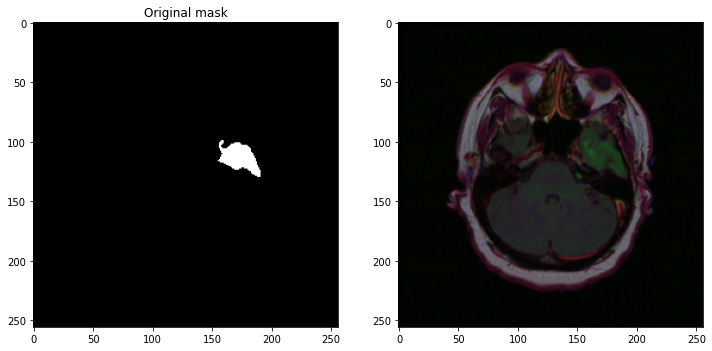

In [ ]:
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Original mask')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));

In [ ]:
cv2.imread(brain_df.mask_path[i]).max(), cv2.imread(brain_df.mask_path[i]).min()

(255, 0)

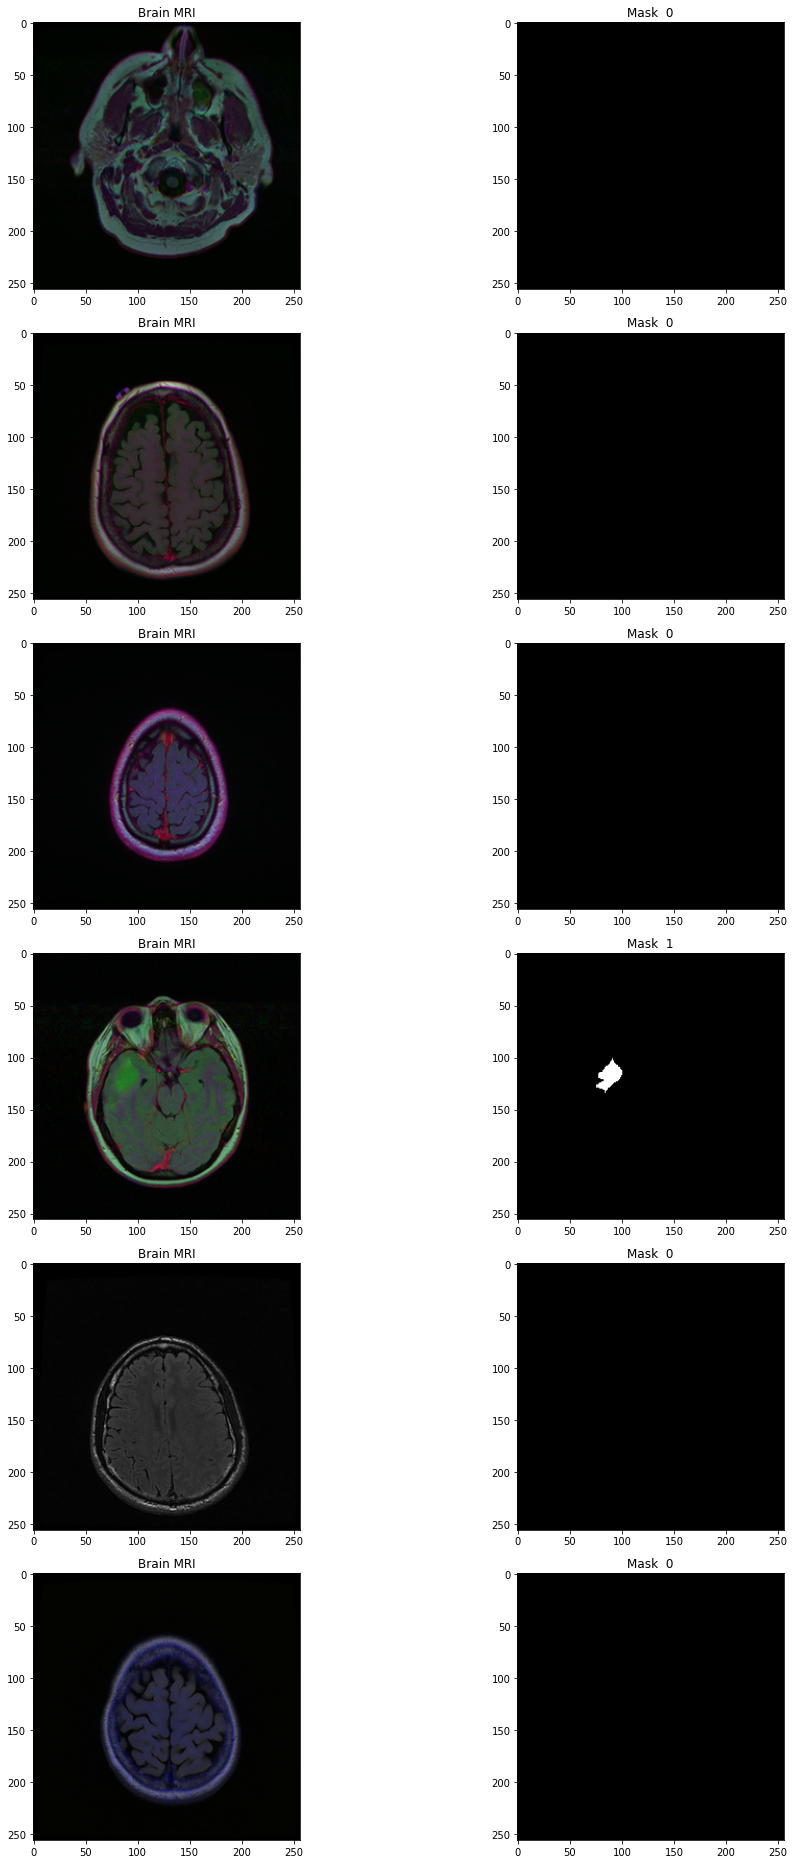

In [ ]:
fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) 
  axs[count][0].title.set_text("Brain MRI")
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) 
  axs[count][1].title.set_text("Mask  " + str(brain_df['mask'][i])) 
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) 
  count += 1

fig.tight_layout()

**Visualizig and highlighting the original mask separately and transposed over the original brain MRI**

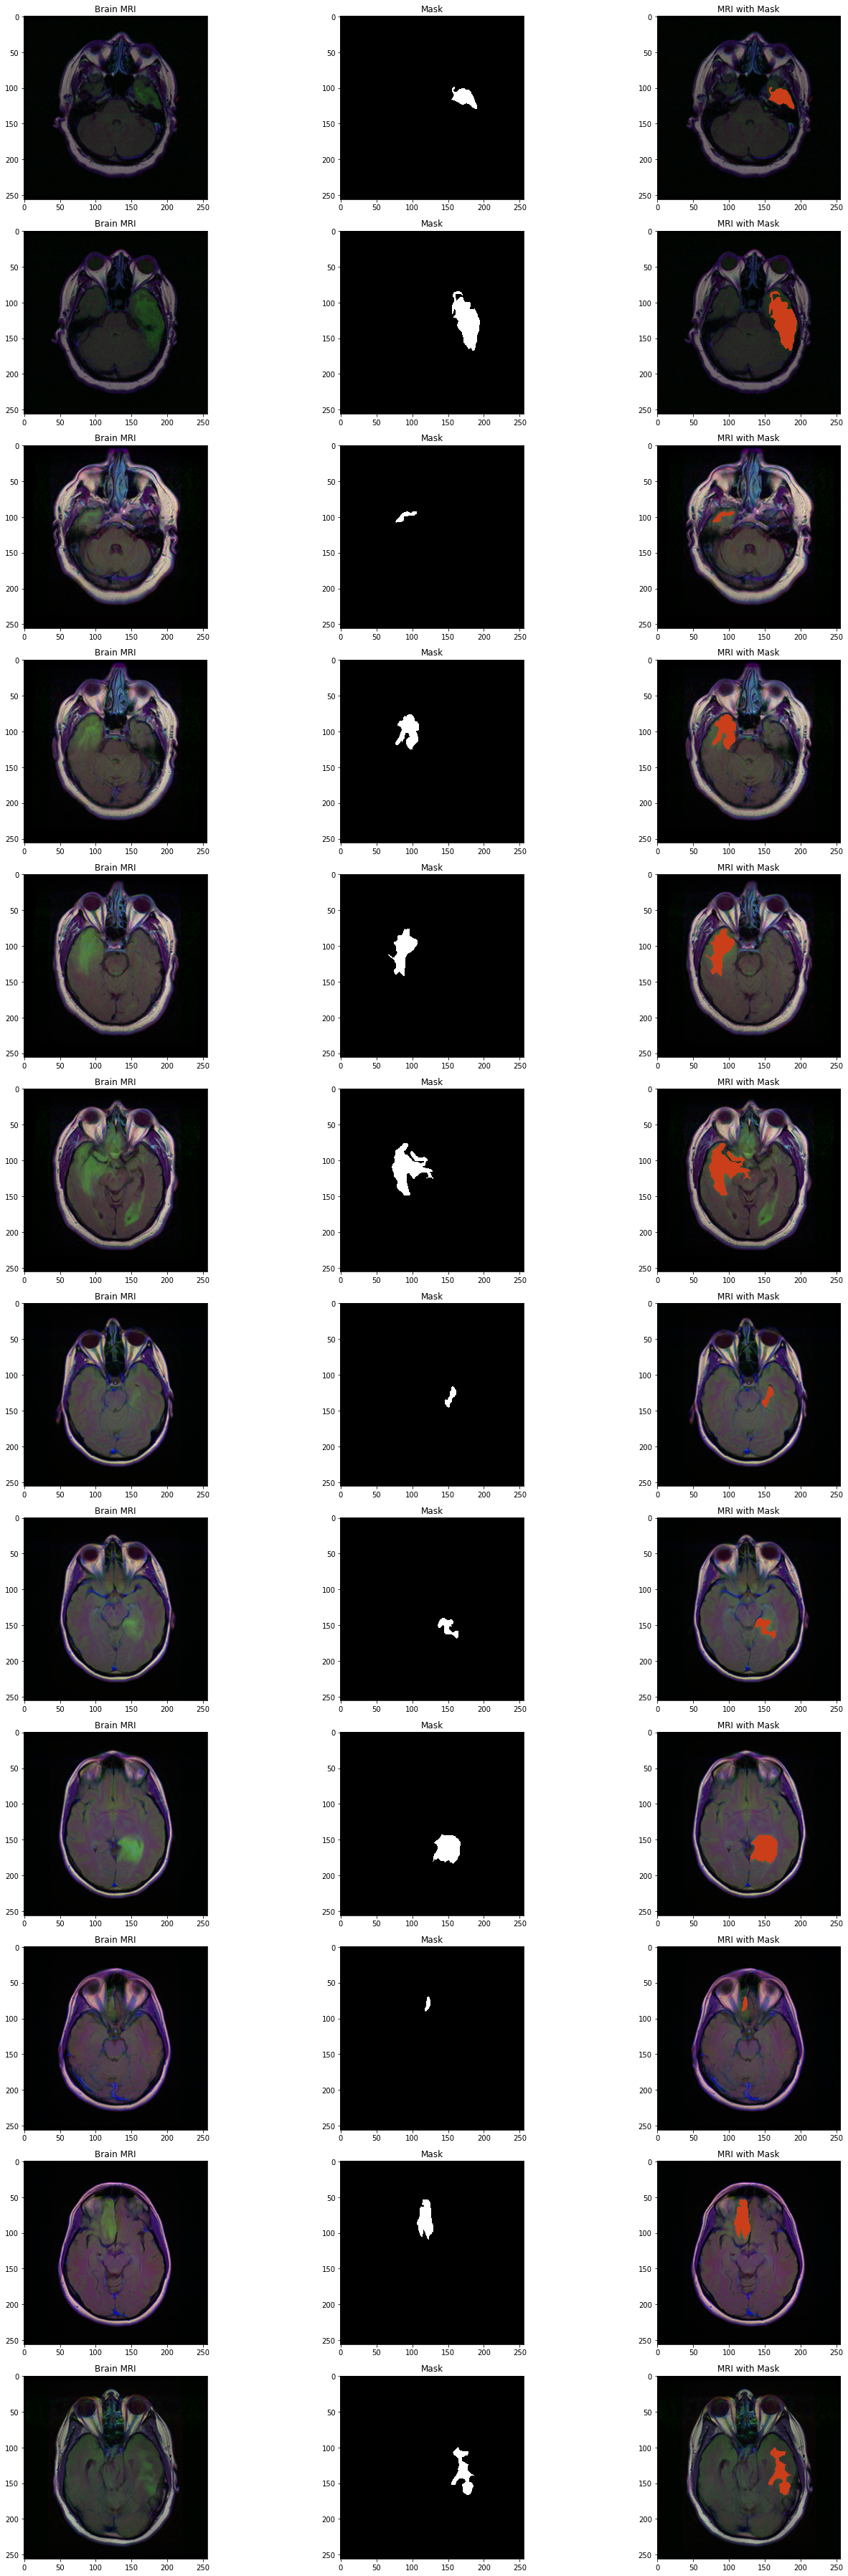

In [ ]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (458,62,25)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break
        
fig.tight_layout()

In [ ]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


***Data splitting***

When developing a deep learning-based method, using a rigorous evaluation process is essential to avoid overfitting to training data or the generation of fake information. In order to evaluate the performance of the network, it is generally recommended to split data into training, valid, and test sets. The training set data are used to determine the network parameters. In most cases, the network shows good performance for the training set after an iterative learning process with the proper adjustment of the network structure and its hyperparameters, due to its very high capacity. Therefore, the separate validation set is required to predict the general performance of the network. The data in the validation set should not be fed into the network because the model should have the ability to apply external data not included in the training process.



In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.15)

***Data Augmentation***

The amount of data gathered was very low and could cause the models to under-fit. Hence, we would use a brilliant technique of Data Augmentation to increase the amount of data. This technique relies on rotations, flips, change in exposure, etc to create similar images. Using this technique we can increase the size of data by a high factor. The output image of the cropping stage is given as input to ImageDataGenerator which is a function in keras.preprocessing.image library. This function takes multiple arguments that decide how Augmentation takes place.

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


**Train a classifier model to detect tumor diagnosis**

The next step is to build and train a model able to classify tumor in the dataset. For this task I've chosen the ***EffNetB0 model***. The effectiveness of model scaling relies heavily on the baseline network. So, to further improve performance, the creators developed a new baseline network by performing a neural architecture search using the AutoML MNAS framework, which optimizes both accuracy and efficiency (FLOPS). The resulting architecture uses mobile inverted bottleneck convolution (MBConv), similar to MobileNetV2 and MnasNet, but is slightly larger due to an increased FLOP budget. It scales up the baseline network to obtain a family of models, called EfficientNets.

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
effnet = EfficientNetB0(weights = "imagenet",include_top=False,input_shape=(256,256,3))
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,MaxPooling2D,Dropout,GlobalAveragePooling2D

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
checkpoint = ModelCheckpoint( "effnet.h5" ,monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'auto', verbose = 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [ ]:
ef_model = effnet.output
ef_model = GlobalAveragePooling2D()(ef_model)
ef_model = Dropout(0.5)(ef_model)
ef_model = Dense(2,activation = "softmax")(ef_model)

ef_model = Model(inputs = effnet.input,outputs = ef_model)
ef_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

***Compiling the model***

In [ ]:
from tensorflow.keras.optimizers import Adam
ef_model.compile(optimizer=Adam(lr=0.0001),loss="categorical_crossentropy",metrics = ["accuracy"])

***Training the model***

In [ ]:
#train the EffNet model
history = ef_model.fit(train_generator, 
                    steps_per_epoch= train_generator.n // train_generator.batch_size, 
                    epochs = 30, 
                    validation_data= valid_generator, 
                    validation_steps= valid_generator.n // valid_generator.batch_size, 
                    callbacks=[checkpoint,earlystop,reduce_lr])

Epoch 1/30
187/187 [==============================] - 47s 211ms/step - loss: 0.4993 - accuracy: 0.7347 - val_loss: 0.6700 - val_accuracy: 0.6031

Epoch 00001: val_accuracy improved from -inf to 0.60312, saving model to effnet.h5
Epoch 2/30
187/187 [==============================] - 38s 204ms/step - loss: 0.2180 - accuracy: 0.9149 - val_loss: 0.6008 - val_accuracy: 0.6531

Epoch 00002: val_accuracy improved from 0.60312 to 0.65312, saving model to effnet.h5
Epoch 3/30
187/187 [==============================] - 38s 205ms/step - loss: 0.1259 - accuracy: 0.9597 - val_loss: 1.0443 - val_accuracy: 0.6125

Epoch 00003: val_accuracy did not improve from 0.65312
Epoch 4/30
187/187 [==============================] - 39s 207ms/step - loss: 0.1006 - accuracy: 0.9658 - val_loss: 0.5806 - val_accuracy: 0.6969

Epoch 00004: val_accuracy improved from 0.65312 to 0.69687, saving model to effnet.h5
Epoch 5/30
187/187 [==============================] - 39s 207ms/step - loss: 0.0605 - accuracy: 0.9782 - v

***Plot validation loss and accuracy***

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

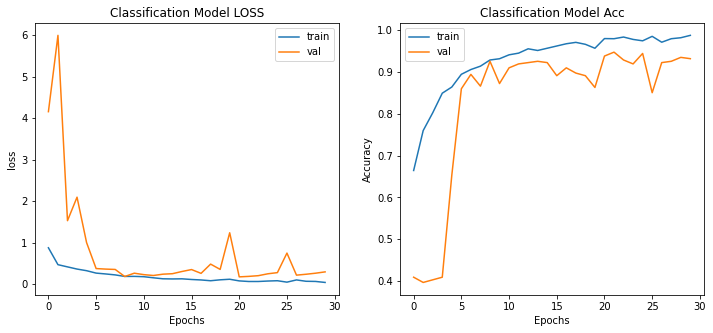

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_class.history['loss']);
plt.plot(history_class.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history_class.history['accuracy']);
plt.plot(history_class.history['val_accuracy']);
plt.title("Classification Model Accuracy");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

***Accuracy model evaluation***

We use a Confusion matrix to analyse how the model performs.

In [ ]:
_, acc = ef_model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

37/37 [==============================] - 2s 48ms/step - loss: 0.1395 - accuracy: 0.9644
Test accuracy : 96.44067883491516 %


*We achieved a great accuracy in classification task over 96%*

**Now let's create a confusion matrix and a classification report**

0.964406779661017
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       401
           1       0.97      0.92      0.94       189

    accuracy                           0.96       590
   macro avg       0.97      0.95      0.96       590
weighted avg       0.96      0.96      0.96       590



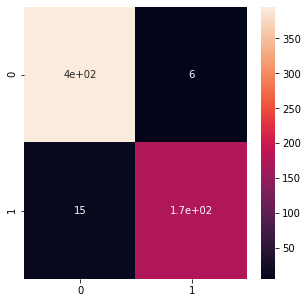

In [ ]:
prediction = ef_model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

***Building the first segmentation model to localize the tumor: ResUNet-a***

The framework consists of a novel deep learning architecture, ResUNet-a. ResUNet-a uses a UNet encoder/decoder backbone, in combination with residual connections, atrous convolutions, pyramid scene parsing pooling and multi-tasking inference. ResUNet-a infers sequentially the boundary of the objects, the distance transform of the segmentation mask, the segmentation mask and a colored reconstruction of the input. Each of the tasks is conditioned on the inference of the previous ones, thus establishing a conditioned relationship between the various tasks.

In [ ]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [ ]:
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1167, valid size is 103 & test size is 103


***Data generator, data augmentation and adjust data***

We generate image and mask at the same time use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same.

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])
      
      #mask path
      mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

***ResUNet Model Creation***

With the widespread use of deep learning methods, semantic segmentation has achieved great improvements in recent years. However, many researchers have pointed out that with multiple uses of convolution and pooling operations, great information loss would occur in the extraction processes. To solve this problem, various operations or network architectures have been suggested to make up for the loss of information. ResUnet consists of a symteric type network, with both parts representing the “encoding” and “decoding” stages. By “upsampling” operations in the “decoding” stage, feature maps are constructed in a certain way that would more or less make up for the losses in previous layers.
The network architecture consists of a contracting
path (left side) and an expansive path (right side). The contracting path follows
the typical architecture of a convolutional network. It consists of the repeated
application of two 3x3 convolutions (unpadded convolutions), each followed by
a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2
for downsampling. At each downsampling step we double the number of feature
channels. Every step in the expansive path consists of an upsampling of the
feature map followed by a 2x2 convolution (“up-convolution”) that halves the
number of feature channels, a concatenation with the correspondingly cropped
feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in
every convolution. At the final layer a 1x1 convolution is used to map each 64-
component feature vector.

In [ ]:
# lets create model now
def resblock(X, f):
    '''
    function for creating res block
    '''
    X_copy = X  #copy of input
    
    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    # Adding the output from main path and short path together
    X = Add()([X, X_copy])
    X = Activation('relu')(X)
    
    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

In [ ]:
input_shape = (256,256,3)
X_input = Input(input_shape) #iniating tensor of input shape

# Stage 1
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

# stage 2
conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2,2))(conv_2)

# Stage 3
conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2,2))(conv_3)

# Stage 4
conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2,2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = resblock(pool_4, 256)

# Upsample Stage 1
up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

# Upsample Stage 2
up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

# Upsample Stage 3
up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

# Upsample Stage 4
up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

# final output
out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

seg_model = Model(X_input, out)
seg_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 256, 256, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 256, 256, 16) 64          conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 16) 2320        batch_normalization_26[0][0]     
____________________________________________________________________________________________

***Defining a custom loss***

We define a custom loss function for ResUNet model called focal tversky to address the issue of data imbalance in medical image segmentation. Compared to the commonly used Dice loss, our loss function achieves a better trade off between precision and recall when training on small structures such as lesions

In [ ]:
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

***Compiling the model***

In [ ]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
seg_model.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-segModel-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

***Training the model***

In [ ]:
h_1 = seg_model.fit(train_data, 
                  epochs = 60, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/60
72/72 [==============================] - 16s 183ms/step - loss: 0.9126 - tversky: 0.1146 - val_loss: 0.8701 - val_tversky: 0.1691

Epoch 00001: val_loss improved from inf to 0.87014, saving model to ResUNet-segModel-weights.hdf5
Epoch 2/60
72/72 [==============================] - 13s 176ms/step - loss: 0.7341 - tversky: 0.3345 - val_loss: 0.6133 - val_tversky: 0.4781

Epoch 00002: val_loss improved from 0.87014 to 0.61328, saving model to ResUNet-segModel-weights.hdf5
Epoch 3/60
72/72 [==============================] - 13s 176ms/step - loss: 0.4160 - tversky: 0.6863 - val_loss: 0.5012 - val_tversky: 0.5994

Epoch 00003: val_loss improved from 0.61328 to 0.50117, saving model to ResUNet-segModel-weights.hdf5
Epoch 4/60
72/72 [==============================] - 13s 177ms/step - loss: 0.3633 - tversky: 0.7384 - val_loss: 0.4558 - val_tversky: 0.6476

Epoch 00004: val_loss improved from 0.50117 to 0.45582, saving model to ResUNet-segModel-weights.hdf5
Epoch 5/60
72/72 [==========

***Model evaluation***

In [ ]:
h_1.history.keys()

dict_keys(['loss', 'tversky', 'val_loss', 'val_tversky', 'lr'])

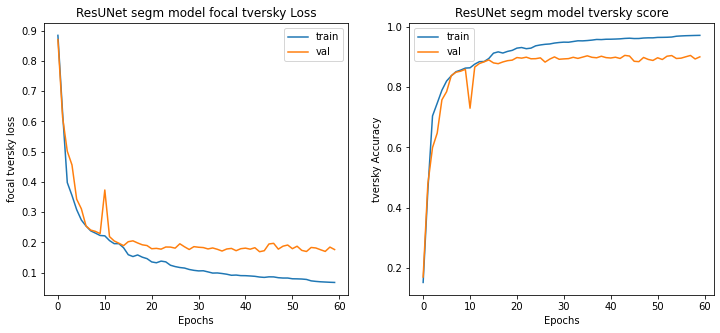

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h_1.history['loss']);
plt.plot(h_1.history['val_loss']);
plt.title("ResUNet segm model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h_1.history['tversky']);
plt.plot(h_1.history['val_tversky']);
plt.title("ResUNet segm model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

6/6 [==============================] - 1s 116ms/step - loss: 0.1747 - tversky: 0.9011
Segmentation tversky is 90.11%


*We got a great tuersky score of 90.1 %.*

***Building the second segmentation model to localize the tumor: UNet***

This architecture consists of three sections: The contraction, The bottleneck, and the expansion section. The contraction section is made of many contraction blocks. Each block takes an input applies two 3X3 convolution layers followed by a 2X2 max pooling. The number of kernels or feature maps after each block doubles so that architecture can learn the complex structures effectively. The bottommost layer mediates between the contraction layer and the expansion layer. It uses two 3X3 CNN layers followed by 2X2 up convolution layer.

In [ ]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)
    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)
    
    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
seg_model_2 = unet()
seg_model_2.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 256, 256, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
activation_32 (Activation)      (None, 256, 256, 64) 0           conv2d_54[0][0]                  
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 256, 256, 64) 36928       activation_32[0][0]              
____________________________________________________________________________________________

***Compiling the model***

In [ ]:
seg_model_2 = unet(input_size=(256, 256, 3))
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
seg_model_2.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )

***Training the model***

In [ ]:
h_2 = seg_model_2.fit(train_data, 
                  epochs = 60, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping]
                 )

Epoch 1/60
72/72 [==============================] - 54s 742ms/step - loss: 0.4080 - tversky: 0.6949 - val_loss: 0.6273 - val_tversky: 0.4618

Epoch 00001: val_loss did not improve from 0.16918
Epoch 2/60
72/72 [==============================] - 55s 758ms/step - loss: 0.3963 - tversky: 0.7060 - val_loss: 0.5422 - val_tversky: 0.5566

Epoch 00002: val_loss did not improve from 0.16918
Epoch 3/60
72/72 [==============================] - 56s 772ms/step - loss: 0.3450 - tversky: 0.7561 - val_loss: 0.6691 - val_tversky: 0.4107

Epoch 00003: val_loss did not improve from 0.16918
Epoch 4/60
72/72 [==============================] - 56s 773ms/step - loss: 0.3292 - tversky: 0.7708 - val_loss: 0.4381 - val_tversky: 0.6636

Epoch 00004: val_loss did not improve from 0.16918
Epoch 5/60
72/72 [==============================] - 56s 783ms/step - loss: 0.2933 - tversky: 0.8032 - val_loss: 0.5854 - val_tversky: 0.5090

Epoch 00005: val_loss did not improve from 0.16918
Epoch 6/60
72/72 [=================

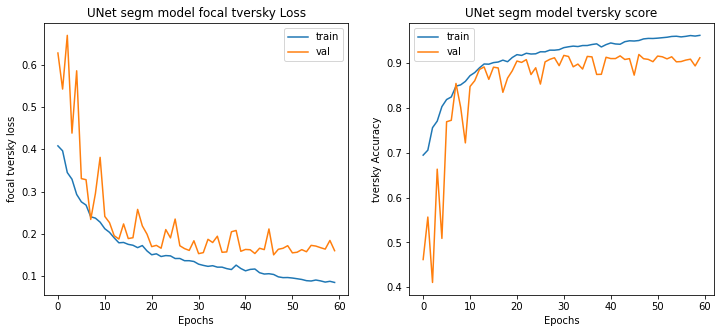

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h_2.history['loss']);
plt.plot(h_2.history['val_loss']);
plt.title("UNet segm model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h_2.history['tversky']);
plt.plot(h_2.history['val_tversky']);
plt.title("UNet segm model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
_, tv_1 = seg_model_2.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv_1*100))

6/6 [==============================] - 2s 221ms/step - loss: 0.1433 - tversky: 0.9246
Segmentation tversky is 92.46%


*Even with U-Net we got a great Tuersky score of 92.4%!*

***Final Step***

Now we have three models: two accurate models that predict the mask (ResUNet-a vs UNet) and classification model (EffNetB0) that is able to classify a tumor. The last step is to combine the three models and visualize the overall performance.

***Classification and ResUNet-a Model combination***

In [ ]:
def prediction(test, ef_model, model_seg):

    # empty list to store results
    mask, image_id, has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.image_path:
        
        img = io.imread(i)
        #normalizing
        img = img *1./255.
        #reshaping
        img = cv2.resize(img, (256,256))
        # converting img into array
        img = np.array(img, dtype=np.float64)
        #reshaping the image from 256,256,3 to 1,256,256,3
        img = np.reshape(img, (1,256,256,3))
        
        #making prediction for tumor in image
        is_defect = ef_model.predict(img)
        
        #if tumour is not present we append the details of the image to the list
        if np.argmax(is_defect)==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
            continue
        
        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

***Classification and UNet Model combination***

In [ ]:
def prediction(test, ef_model, seg_model_2):

    # empty list to store results
    mask, image_id, has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.image_path:
        
        img = io.imread(i)
        #normalizing
        img = img *1./255.
        #reshaping
        img = cv2.resize(img, (256,256))
        # converting img into array
        img = np.array(img, dtype=np.float64)
        #reshaping the image from 256,256,3 to 1,256,256,3
        img = np.reshape(img, (1,256,256,3))
        
        #making prediction for tumor in image
        is_defect = ef_model.predict(img)
        
        #if tumour is not present we append the details of the image to the list
        if np.argmax(is_defect)==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
            continue
        
        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make prediction of mask with UNet
        predict_1 = seg_model_2.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict_1.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict_1)

    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [ ]:
# making prediction
df_pred = prediction(test, ef_model, seg_model)
df_pred

image_path  ... has_mask
0    /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
1    /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
2    /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        1
3    /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        1
4    /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        1
..                                                 ...  ...      ...
585  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
586  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
587  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        1
588  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
589  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0

[590 rows x 3 columns]

In [ ]:
# merging original and prediction df
df_pred = test.merge(df_pred, on='image_path')
df_pred.head(10)

image_path  ... has_mask
0  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
1  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
2  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        1
3  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        1
4  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        1
5  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        1
6  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
7  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
8  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
9  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0

[10 rows x 7 columns]

In [ ]:
df_pred_1 = prediction(test, ef_model, seg_model_2)
df_pred_1

image_path  ... has_mask
0    /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
1    /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
2    /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        1
3    /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        1
4    /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        1
..                                                 ...  ...      ...
585  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
586  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
587  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        1
588  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
589  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0

[590 rows x 3 columns]

In [ ]:
df_pred_1 = test.merge(df_pred_1, on='image_path')
df_pred_1.head(10)

image_path  ... has_mask
0  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
1  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
2  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        1
3  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        1
4  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        1
5  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        1
6  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
7  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
8  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0
9  /content/drive/MyDrive/lgg-mri-segmentation/ka...  ...        0

[10 rows x 5 columns]

***Visualizing predicted masks with ResUNet-a vs original masks***

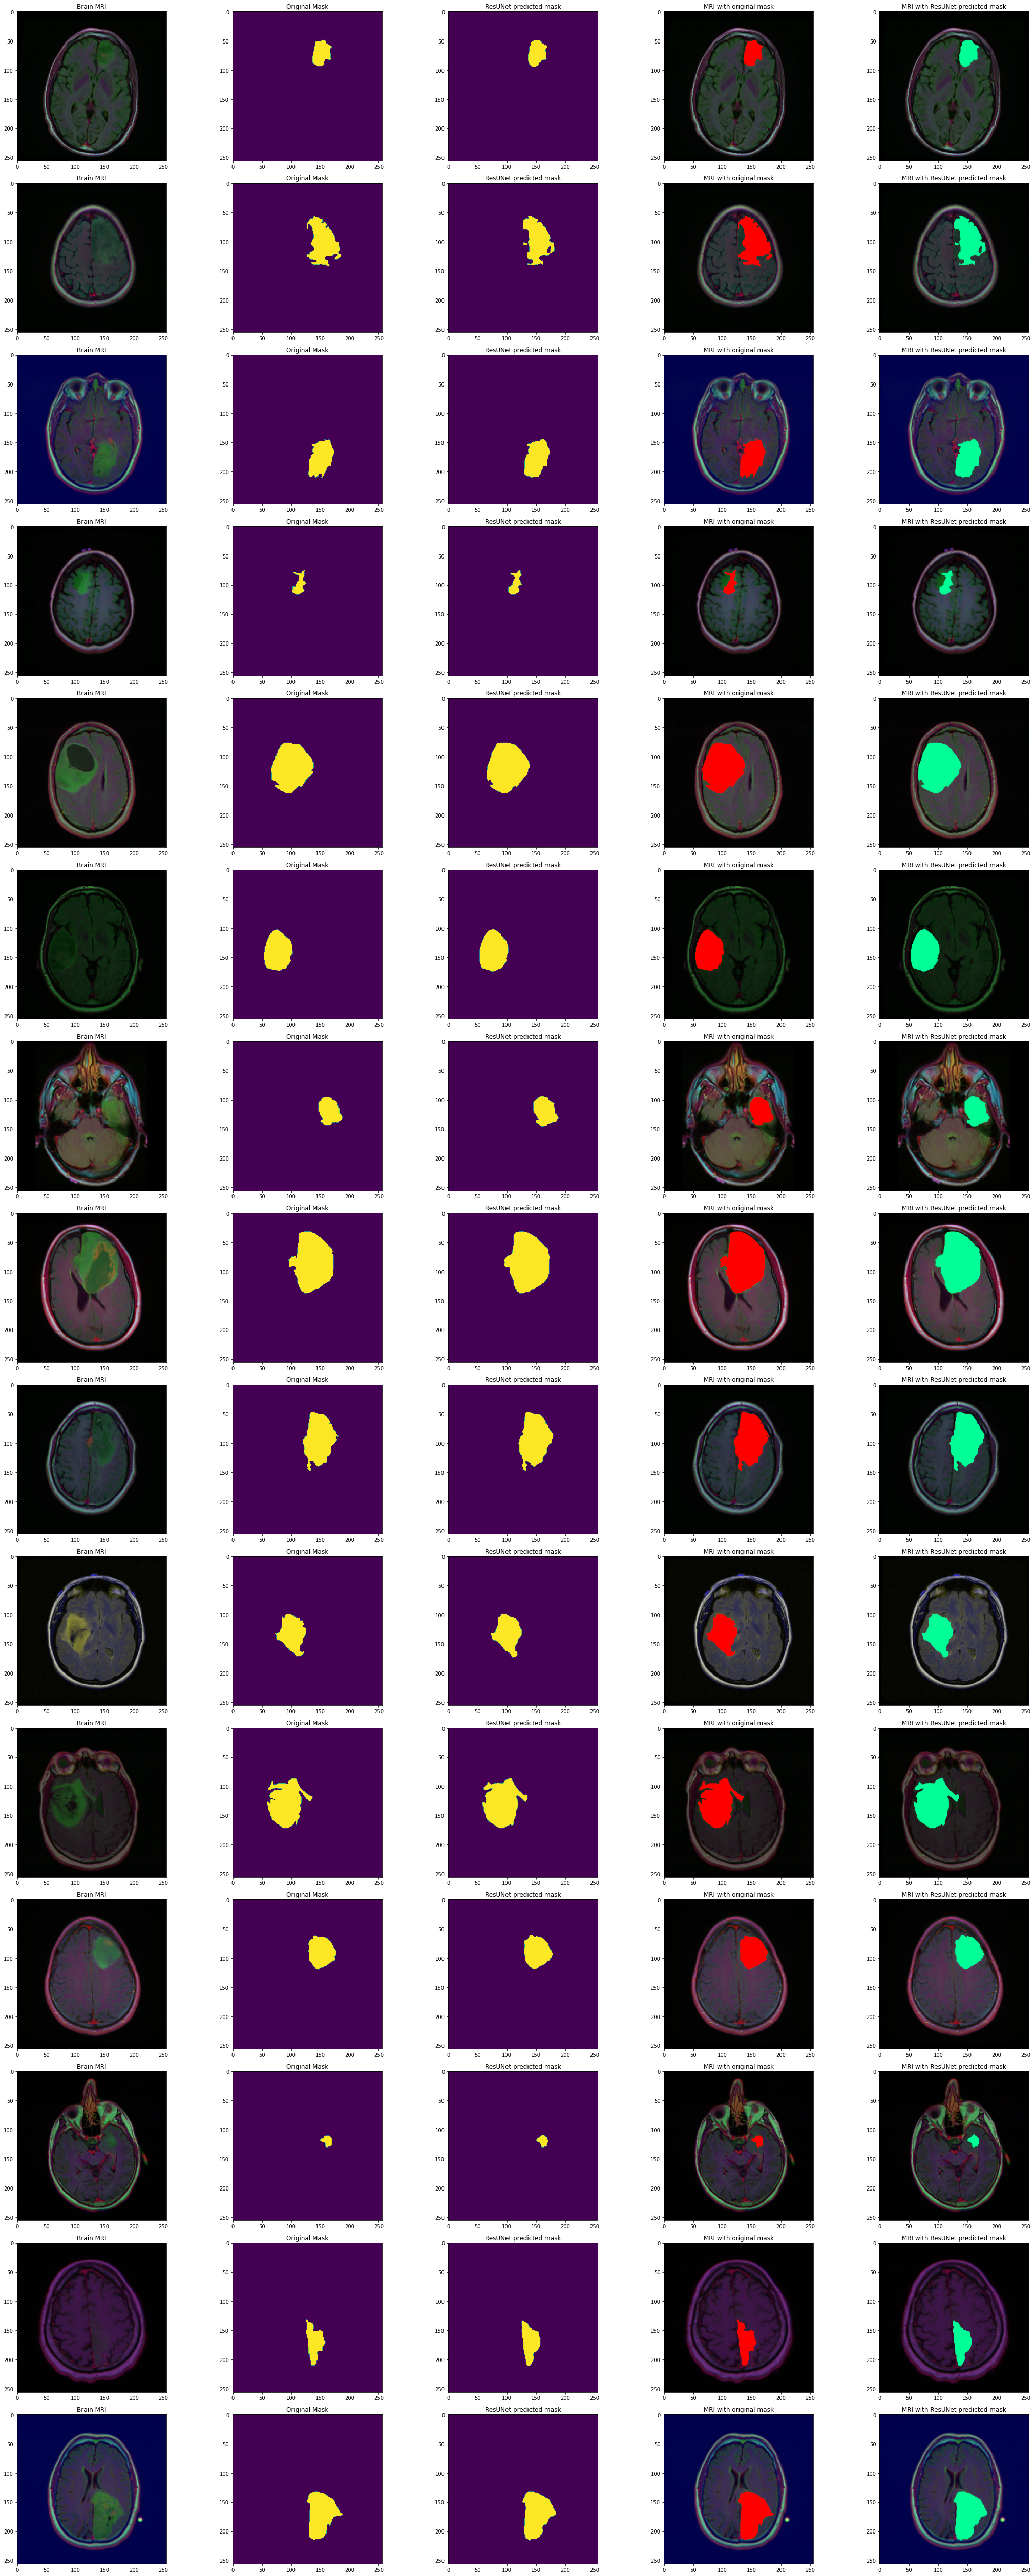

In [ ]:
#visualizing prediction
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('ResUNet predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('MRI with original mask')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with ResUNet predicted mask')
        
        count +=1
    if (count==15):
        break

fig.tight_layout()        

As we can see the predictions made by segmentation model are almost correct and correspond to the original mask.

***Visualizing predicted masks with ResUNet-a vs original masks***

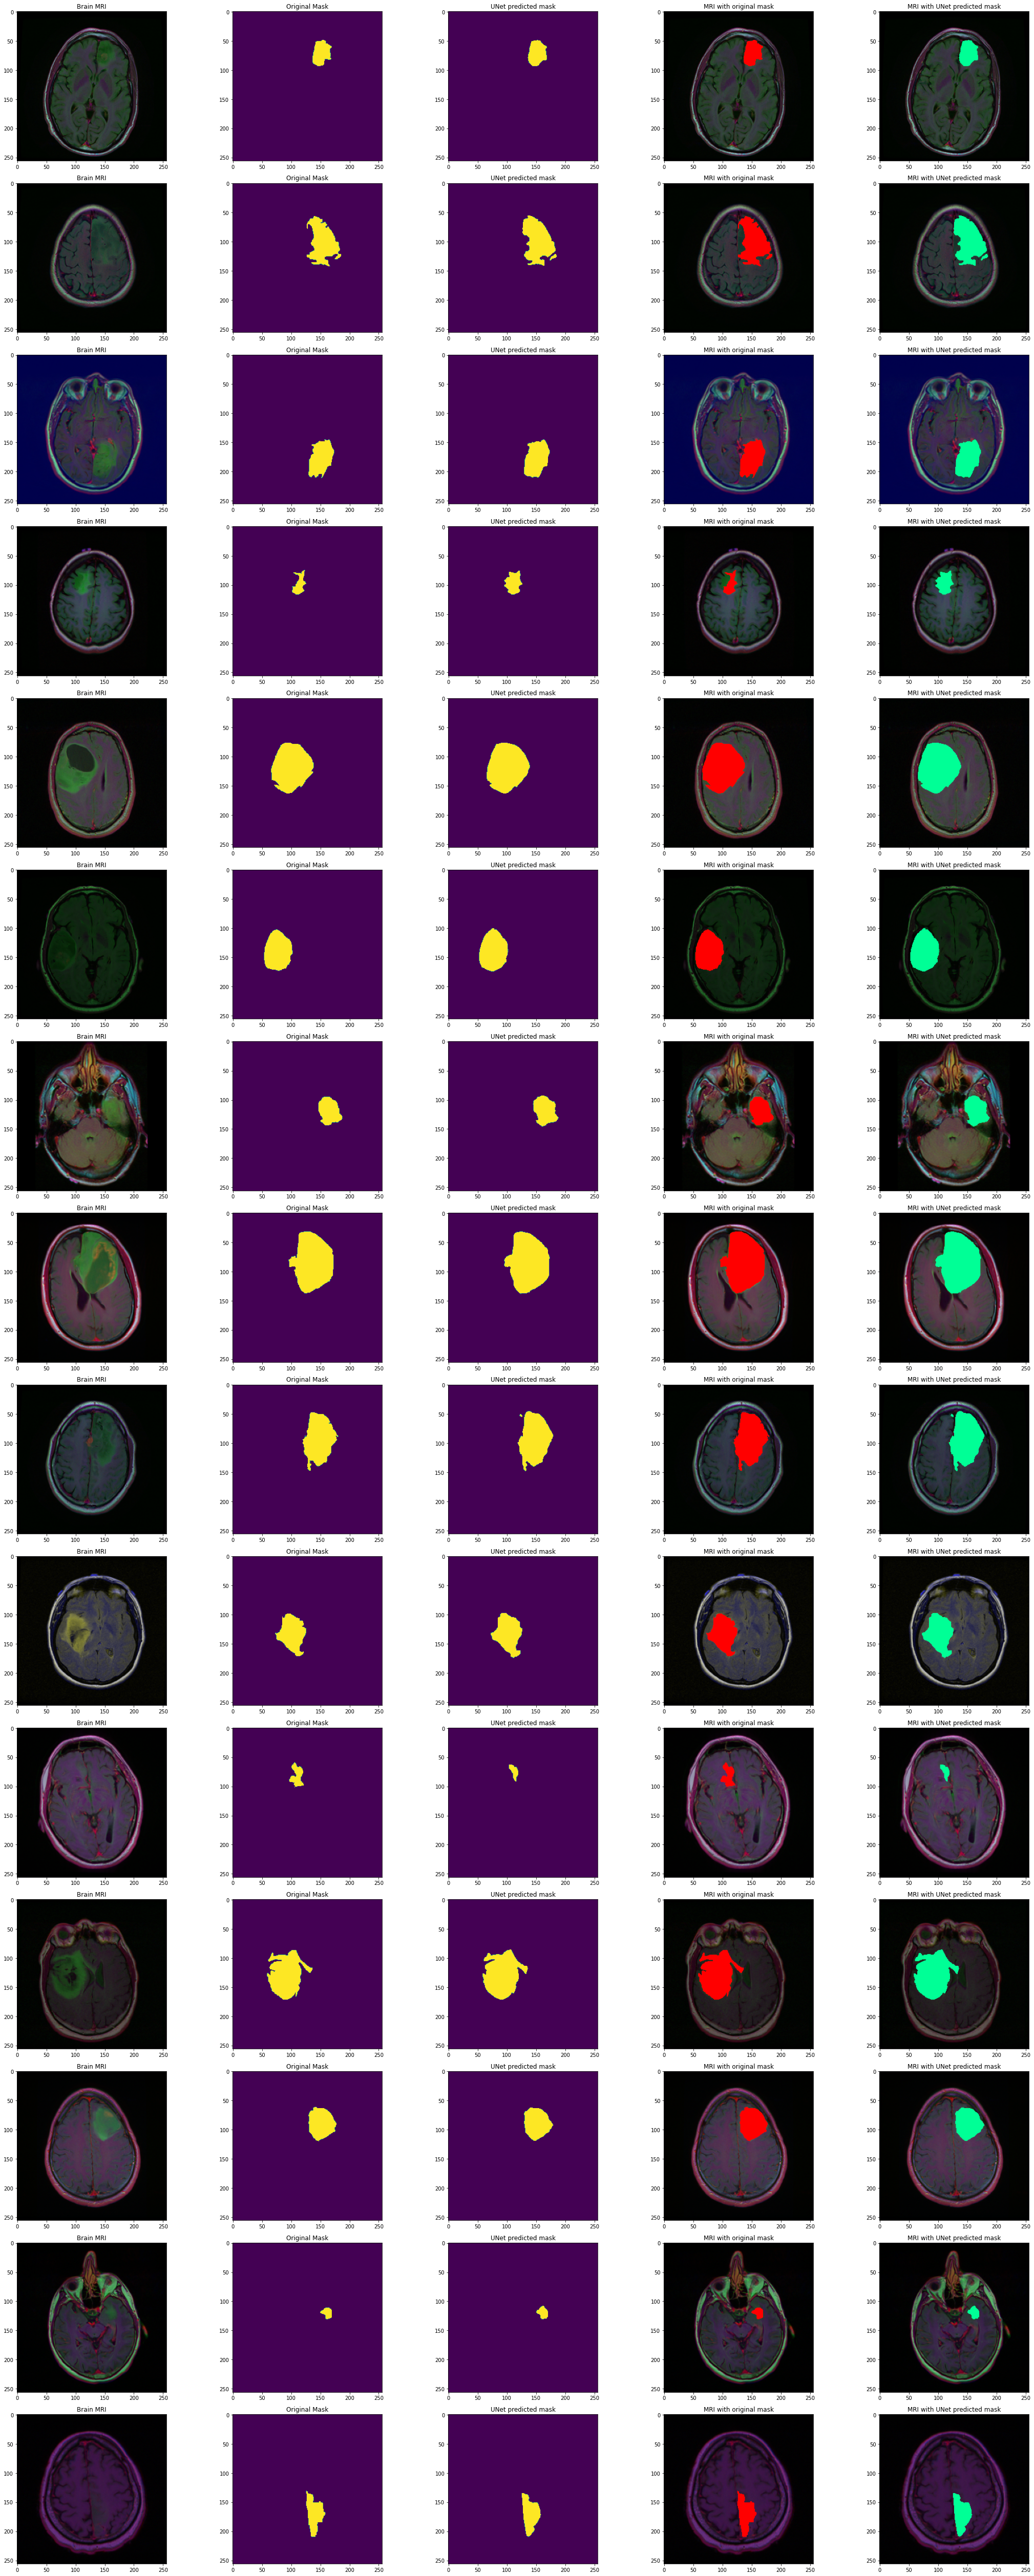

In [ ]:
#visualizing prediction
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred_1)):
    if df_pred_1.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred_1.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred_1.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')
        
        #read predicted mask
        pred_1 = np.array(df_pred_1.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred_1)
        axs[count][2].title.set_text('UNet predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('MRI with original mask')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred_1.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred_1==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with UNet predicted mask')
        
        count +=1
    if (count==15):
        break

fig.tight_layout()        